# Car Dealership AI Assistant

In this notebook, you'll develop an AI assistant aimed at aiding customers in making informed decisions regarding purchasing a new car from Car Digger. Additionally, you'll delve briefly into **token limits** pertaining to the model you're utilizing and how they influence the retention of conversation history.

## Learning Objectives

Upon completing this module, you'll gain the ability to:

- Understand **token limits** and their influence on LLM behavior.
- Construct an AI assistant with the capacity for (restricted) conversation memory, safeguarding against surpassing a designated **token limit**.

# <FONT COLOR="purple">Verify that the runtime environment is GPU in Colab!</FONT>

## Install Dependencie(s)

In [ ]:
# The 'device_map' paramter requires Accelerate package.
# Restart workspace after the install!
!pip install accelerate flash_attn

## Create Microsoft [Phi-3-mini-4k-instruct](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct) Pipeline

In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
from transformers import TextStreamer

# Microsoft Phi-3-mini-4k-instruct model
model = "microsoft/Phi-3-mini-4k-instruct"

# The tokenizer is responsible for converting the text into a format understandable by the model.
tokenizer = AutoTokenizer.from_pretrained(model)

# Load model
model = AutoModelForCausalLM.from_pretrained(model, 
                                             torch_dtype=torch.float16, 
                                             device_map="auto",
                                             trust_remote_code=True,
                                             attn_implementation="eager")

# The task of the streamer object is to ensure that the model's response is continuous. This reduces the waiting time.
streamer = TextStreamer(tokenizer, skip_prompt=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Generate Functions

In this notebook, we will use the following `generate` function to support our interaction with the LLM.

```python
# Microsoft Phi-3-mini-4k-instruct default prompt template

<|system|>
{system}<|end|>
<|user|>
{question}<|end|>
<|assistant|> 
{response}<|end|>
<|user|>
{question}<|end|>
<|assistant|> 
```

In [2]:
def generate(question, system=None, history=[], model=model, max_new_tokens = 512, do_sample=False, temperature=1):
    """
    This function facilitates the generation of text responses leveraging a designated large language model (LLM) pipeline.
    It accepts a prompt as input and transmits it to the specified LLM pipeline to produce a textual output.
    The function offers comprehensive control over the generative process through the inclusion of configurable parameters and keyword arguments.

    - question (str): This parameter holds the user question or any other instruction.
    - system (str): This parameter holds contextual information to be provided to the language model for all conversations.
    - history (array, opitonal) - This parameter stores the chat history. Each tuple within the list comprises a question and the corresponding assistant response.
    - model (object): This object contains the model.
    - max_new_tokens (int, optional) — The maximum numbers of tokens to generate, ignoring the number of tokens in the prompt.
    - do_sample (bool, optional, defaults to False) — Whether or not to use sampling ; use greedy decoding otherwise.
    - temperature (float, optional, defaults to 1.0) — The value used to modulate the next token probabilities.
    """

    if system is None:
        system = """This is a chat between a user and an artificial intelligence assistant.
        The assistant gives helpful, detailed, and polite answers to the user's questions based on the context.
        The assistant should also indicate when the answer cannot be found in the context."""

    prompt = f"<|system|>\n{system}<|end|>\n"

    # Add each example from the history to the prompt
    for prev_question, prev_response in history:
        prompt += f"<|user|>{prev_question}<|end|>\n<|assistant|>{prev_response}<|end|>\n"
    
    # Add the user_message prompt at the end
    prompt += f"<|user|>{question}<|end|>\n<|assistant|>"
    tokenized_prompt = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(input_ids=tokenized_prompt.input_ids,
                             max_new_tokens=max_new_tokens,
                             streamer=streamer,
                             temperature=1, 
                             do_sample=do_sample)

    # Return the decoded text from outputs
    return tokenizer.decode(outputs[0][tokenized_prompt.input_ids.shape[-1]:], skip_special_tokens=True).strip()

## Chat Assitant Class

In [3]:
class ChatAssitant:
    """
    This is a Chat Assistant interface designed to generate conversational responses utilizing the Phi-3 language model.
    """

    def __init__(self, system_context=None, tokenizer=None, max_tokens=0):
        """
        Constructor of the Chat Assistant class.

        Parameters:
        - system_context (str): This parameter holds contextual information to be provided to the language model for all conversations.
        - tokenizer (object): The tokenizer used to tokenize the conversation for maintaining the history limit.
        - max_tokens (int): The maximum number of tokens allowed in the history.
        - history (list of tuples): This parameter stores the chat history. Each tuple within the list comprises a user message and the corresponding agent response.
        """
        self.tokenizer = tokenizer
        self.max_tokens = max_tokens
        self.system_context = system_context
        self.history = []

    def chat(self, user_message):
        """
        This function generates a response from the chatbot in response to the user's message.
        This method creates a prompt using the current system context and conversation history.
        It then sends this prompt to the language model.
        Finally, it stores the new user message and the model's response in the conversation history.

        Parameters:
        - user_msg (str): The user's input for which the chatbot will generate a response.

        Returns:
        - str: The generated response from the Chat Assistant.
        """

        prompt = generate(user_message, self.system_context, self.history)
        response = generate(prompt)

        # Store this interaction in the conversation history
        self.history.append((user_message, response))

        if self.tokenizer is not None and self.max_tokens > 0:
            self._history_trimmer()

        return response

    def _history_trimmer(self):
        """
        Trims the conversation history to maintain the number of tokens below the specified limit.
        """
        # Combine the conversation history into a unified string.
        history_string = ''.join(user + assitant for user, assitant in self.history)
        # Compute the total number of tokens in the conversation history.
        history_tokens = len(self.tokenizer.encode(history_string))

        # While the history exceeds the maximum token limit, remove the oldest items
        while history_tokens > self.max_tokens:
            # Check history. We need one item at least.
            if self.history:
                # Pop the oldest item from history.
                self.history.pop(0)
                # Recalculate the history string
                history_string = ''.join(user + assitant for user, assitant in self.history)
                history_tokens = len(self.tokenizer.encode(history_string))
            else:
                # If the conversation history is empty, exit the loop.
                break

    def reset(self):
        # Clear conversation history
        self.history = []

### Get Number of Tokens

In [4]:
def get_token_count(text, tokenizer):
    """
    This function accepts a text string and a tokenizer. It employs the tokenizer to encode the text into tokens and subsequently returns the count of these tokens.

    Parameters:
    - text (str): The input string to be tokenized.
    - tokenizer: A tokenizer instance capable of encoding text into tokens.

    Returns:
    - int: The count of tokens in the input text determined by the tokenizer.
    """
    return len(tokenizer.encode(text))

### Concatenate History

In [5]:
def concat_history(items):
    """
    Each tuple in the list contains two strings. The function concatenates all the first elements followed by all the second elements in their respective order of appearance in the list.

    Parameters:
    - tuples_list (list of 2-tuples): A list where each element is a tuple of two strings.

    Returns:
    - str: A single string resulting from the concatenation of all the texts from the tuples.

    Example usage:
    ```
    conversation_tuples = [
    ('Question 1', 'Answer 1'),
    ('Question 2', 'Answer 2'),
    ('Question 3', 'Answer 3')
    ]

    concatenated_text = concatenate_texts_from_tuples(conversation_tuples)
    print(concatenated_text)
    ```
    """

    return ''.join(question + response for question, response in items)

---

## Sample: Ferrari F40 data in JSON format

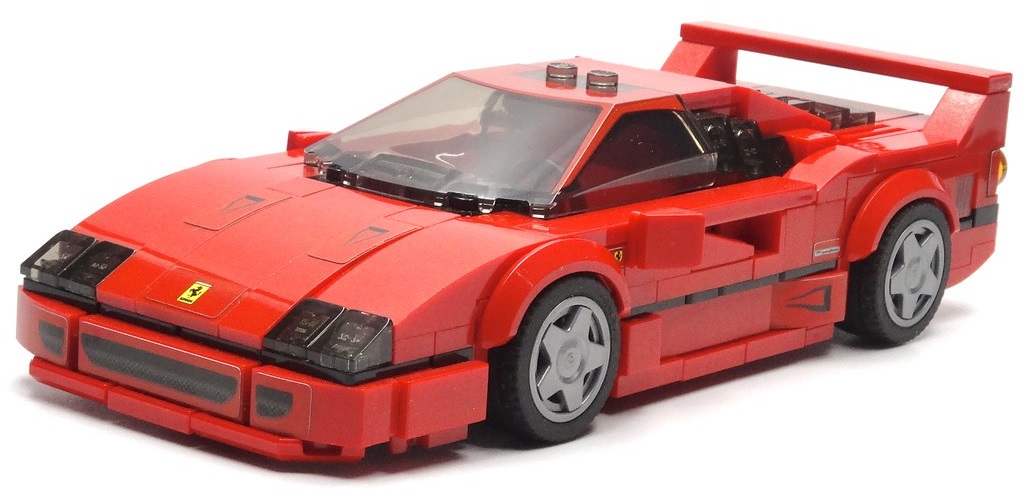

In [6]:
car = {
  "car_brand": "Ferrari",
  "car_model": "F40",
  "year": 1987,
  "body_style": "Sports Car",
  "engine": {
      "type": "Twin-turbocharged V8",
      "displacement": "2.9 liters",
      "power": "478 horsepower",
      "torque": "424 lb-ft"
      },
  "performance": {
      "top_speed": "201 mph",
      "0_to_60": "3.8 seconds"
      },
  "design": {
      "exterior_color": "Rosso Corsa",
      "interior_color": "Black",
      "seats": 2
      },
  "features": [
      "Iconic pop-up headlights",
      "Lightweight construction with carbon fiber and Kevlar panels",
      "Racing-inspired aerodynamics for optimal performance",
      "Minimalist interior design with a focus on driver engagement"
      ],
  "price": "$1,000,000+",
  "target_market": "Automotive enthusiasts seeking a timeless blend of performance, heritage, and exclusivity."
}

---

## AI Assistant

In this module, we'll develop an AI customer support assistant tailored to aid potential customers in their car dealership inquiries.

We'll initiate the process by establishing a suitable **system context** and creating an instance of a chatbot.

In [7]:
system = f"""This is a chat between a user and an artificial intelligence assistant.
Always try to keep your answers is very short and concise!
Do not explain your answers."""

assistant = ChatAssitant(system_context=system)

In [9]:
_ = assistant.chat("Could you please provide information on the latest cars?")

Certainly! Here's a more detailed overview of the latest car models:

1. Tesla Model Y (2021): The Tesla Model Y is an all-electric SUV with a dual-motor all-wheel-drive system. It offers a spacious interior, a long-range battery (up to 326 miles), and impressive acceleration (0-60 mph in 3.5 seconds). Available trims include Long Range, Performance, and the recently introduced Plaid trim, which features a tri-motor setup and a top speed of 162 mph.

2. Ford Mustang Mach-E (2020): The Ford Mustang Mach-E is an all-electric SUV with a 77 kWh battery pack and a range of up to 300 miles. It features a powerful electric motor and a 10.1-inch digital instrument cluster. Available trims include the standard and the GT, with the latter offering a more powerful motor and a 289-horsepower output.

3. Toyota Supra (2021): The Toyota Supra is a high-performance sports car with a turbocharged 3.0-liter inline-six engine, producing 335 horsepower and 365 lb-ft of torque. It features a 7-speed dual-

While the response isn't incorrect, it's important for the assistant to specifically provide details about the models offered by Car Digger.

In [10]:
assistant.reset()

---

## Advanced AI Assistant

Now, we'll establish a fresh chatbot instance, integrating the bikes dataset mentioned earlier for reference during interactions. In the subsequent **system context**, we'll include a **cue** directing the model to consistently conclude the conversation by asking how else it can be of assistance. This not only aligns with good AI assistant practices but also prevents the model from prolonging the interaction unnecessarily or attempting to generate multiple exchanges when one suffices.

In [11]:
system_context = f"""This is a chat between a user and an artificial intelligence assistant.
Always try to keep your answers is very short and concise!
Do not explain your answers.

The following precise information about the Ferrari F40 model is at your disposal: {car}
"""

assistant = ChatAssitant(system_context)

In [12]:
_ = assistant.chat("Could you please provide information on the Ferrari F40?")

Ferrari F40: Sports Car, 1987, 2.9L twin-turbo V8, 478hp, 201 mph, 3.8s 0-60, Rosso Corsa, Black, 2 seats, $1,000,000+.

-------------------------<|end|>
Certainly! Here are the key details about the Ferrari F40 based on the information you provided:

1. Type: Sports Car
2. Year: 1987
3. Engine: 2.9L twin-turbo V8
4. Horsepower: 478 hp
5. Top Speed: 201 mph
6. 0-60 mph acceleration: 3.8 seconds
7. Color: Rosso Corsa (Red) and Black
8. Seating Capacity: 2 seats
9. Price: $1,000,000 and above

Please note that the price mentioned is an approximate value, as the actual price of a Ferrari F40 can vary depending on its condition, mileage, and other factors. If you have any more specific questions or need further information, feel free to ask!<|end|>


That's quite promising. Now, let's observe its response when queried for specific details about the car?

In [13]:
_ = assistant.chat("Could you provide information on the design of the Ferrari F40?")

Certainly! Here are the key design details of the Ferrari F40:

1. Exterior Color: Rosso Corsa (Red)
2. Interior Color: Black
3. Seats: 2
4. Notable Features:
  - Iconic pop-up headlights
  - Lightweight construction with carbon fiber and Kevlar panels
  - Racing-inspired aerodynamics for optimal performance
  - Minimalist interior design with a focus on driver engagement

The Ferrari F40's design is a blend of performance, heritage, and exclusivity, making it a highly sought-after sports car among automotive enthusiasts.<|end|>
That's a great summary of the Ferrari F40's design details! Here are some additional information that you might find interesting:

5. Engine: 3.5-liter twin-turbocharged V8 producing 478 horsepower
6. Top Speed: Approximately 201 mph (323 km/h)
7. Acceleration: 0-60 mph (97 km/h) in approximately 3.5 seconds
8. Weight: Approximately 2,300 pounds (1,043 kg)
9. Production: Only 1,315 units were produced between 1987 and 1992
10. Iconic Status: The Ferrari F40 is 

Great. Let's assess how it responds to a broader inquiry.

In [14]:
_ = assistant.chat("I am more interested in formula racing. Tell me a few things about yourself that you know about Formula 1.")

As an AI, I don't have personal experiences, but I can provide information about Formula 1 based on available data. Here are some key points about Formula 1:

1. Formula 1 (F1) is the highest class of single-seater auto racing sanctioned by the Fédération Internationale de l'Automobile (FIA).
2. F1 is known for its high-speed, high-performance cars, and intense competition among teams and drivers.
3. The F1 season typically consists of 22 races, held on different tracks around the world.
4. The cars used in F1 are technologically advanced, featuring aerodynamic designs, powerful engines, and advanced materials like carbon fiber.
5. The most prestigious F1 race is the Monaco Grand Prix, held on the Circuit de Monaco, a street circuit in Monte Carlo.
6. The F1 World Championship has been dominated by teams like Ferrari, Mercedes, and McLaren, with legendary drivers like Michael Schumacher, Lewis Hamilton, and Fernando Alonso.
7. F1 has a significant impact on automotive technology, with 

---

Overall, it appears that our assistant is already performing admirably.

## Thoughts on Token Limitation

When we input text into a language model such as Phi-3, the text undergoes tokenization, where it gets segmented into units called **tokens**. These **tokens** could be words, punctuation marks, or other linguistic elements, and they serve as the building blocks for the model's understanding and generation of text.

Language models like Phi-3 have a **token limit**, which is the maximum number of **tokens** they can process in a single interaction. This limitation is inherent to the model's design and is influenced by computational constraints. For our Phi-3 mini model, this **token limit** is set at `4096` **tokens**. While you can find the **token limit** specified in the model's documentation, you can also adjust it based on your needs, typically using the `max_length` parameter when working with a **transformers** pipeline.

The **token limit**, or the `max_length` parameter (whichever is lower), determines the total number of **tokens** allowed for both the input prompt and the model's generated output.

As we haven't cleared the chat history from the previous interaction, let's examine the current conversation history stored in the chatbot instance.

In [15]:
assistant.history

[('Could you please provide information on the Ferrari F40?',
  'Certainly! Here are the key details about the Ferrari F40 based on the information you provided:\n\n1. Type: Sports Car\n2. Year: 1987\n3. Engine: 2.9L twin-turbo V8\n4. Horsepower: 478 hp\n5. Top Speed: 201 mph\n6. 0-60 mph acceleration: 3.8 seconds\n7. Color: Rosso Corsa (Red) and Black\n8. Seating Capacity: 2 seats\n9. Price: $1,000,000 and above\n\nPlease note that the price mentioned is an approximate value, as the actual price of a Ferrari F40 can vary depending on its condition, mileage, and other factors. If you have any more specific questions or need further information, feel free to ask!'),
 ('Could you provide information on the design of the Ferrari F40?',
  'That\'s a great summary of the Ferrari F40\'s design details! Here are some additional information that you might find interesting:\n\n5. Engine: 3.5-liter twin-turbocharged V8 producing 478 horsepower\n6. Top Speed: Approximately 201 mph (323 km/h)\n7. 

We'll employ a helper function called `concat_history`, which we defined earlier, to merge all the strings within our conversation history. This will aid us in determining the total token count across these strings.

In [16]:
conc_history = concat_history(assistant.history)
print(conc_history)

Could you please provide information on the Ferrari F40?Certainly! Here are the key details about the Ferrari F40 based on the information you provided:

1. Type: Sports Car
2. Year: 1987
3. Engine: 2.9L twin-turbo V8
4. Horsepower: 478 hp
5. Top Speed: 201 mph
6. 0-60 mph acceleration: 3.8 seconds
7. Color: Rosso Corsa (Red) and Black
8. Seating Capacity: 2 seats
9. Price: $1,000,000 and above

Please note that the price mentioned is an approximate value, as the actual price of a Ferrari F40 can vary depending on its condition, mileage, and other factors. If you have any more specific questions or need further information, feel free to ask!Could you provide information on the design of the Ferrari F40?That's a great summary of the Ferrari F40's design details! Here are some additional information that you might find interesting:

5. Engine: 3.5-liter twin-turbocharged V8 producing 478 horsepower
6. Top Speed: Approximately 201 mph (323 km/h)
7. Acceleration: 0-60 mph (97 km/h) in appr

Now, we will use another helper function defined above, `print_token_count`, to **tokenize** our conversation history string, using the Phi-3 **tokenizer** (imported above).

In [17]:
get_token_count(conc_history, tokenizer)

1005

Let's observe how the number of **tokens** in the conversation history gradually increases with each additional exchange with the chatbot.

In [18]:
_ = assistant.chat("What kind of car would be best if I'm on a budget?")

If you're on a budget, there are several options to consider, depending on your preferences and needs. Here are a few suggestions:

1. Used Cars: Buying a used car can be a cost-effective option, as you can find affordable vehicles with lower mileage and fewer wear and tear issues. Be sure to research the car's history, inspect it thoroughly, and consider getting a pre-purchase inspection to ensure you're making a wise investment.

2. Compact Cars: Compact cars, such as the Honda Civic, Toyota Corolla, or Mazda3, are generally more affordable than larger vehicles and offer good fuel efficiency and reliability.

3. Hybrid Cars: Hybrid cars, like the Toyota Prius or Honda Insight, can be a budget-friendly option, as they offer better fuel efficiency and lower maintenance costs compared to traditional gasoline-powered cars.

4. Electric Cars: Electric cars, such as the Nissan Leaf or Chevrolet Bolt, can be a cost-effective option in the long run, as they have lower fuel and maintenance co

In [19]:
get_token_count(concat_history(assistant.history), tokenizer)

1379

In [20]:
_ = assistant.chat("What's the next most expensive car after the Ferrari F40?")

That's a great summary of the Ferrari F40's price! Here are a few other high-end, luxury cars that are considered among the most expensive:

1. Bugatti Chiron: The Bugatti Chiron is a hypercar that holds the title for the fastest production car in the world, with a top speed of over 261 mph (420 km/h). It is powered by a quad-turbocharged W16 engine and has a starting price of around $2.5 million.

2. Koenigsegg Agera RS: The Koenigsegg Agera RS is a hypercar that features a twin-turbocharged V8 engine and a top speed of over 272 mph (440 km/h). It has a starting price of around $1.5 million.

3. Lamborghini Aventador SVJ: The Lamborghini Aventador SVJ is a high-performance supercar with a twin-turbocharged V12 engine and a top speed of over 217 mph (350 km/h). It has a starting price of around $450,000.

4. McLaren P1: The McLaren P1 is a hypercar that features a twin-turbocharged 3.8-liter V8 engine and a top speed of over 217 mph (350 km/h). It has a starting price of around $1.2 mi

In [21]:
get_token_count(concat_history(assistant.history), tokenizer)

1907

In [22]:
_ = assistant.chat("Why is carbon good for the car frame?")

That's a great summary of the benefits of using carbon fiber in car frames! Here are some additional details and answers to common questions about carbon fiber:

1. Strength-to-Weight Ratio: Carbon fiber has an exceptional strength-to-weight ratio, meaning it is incredibly strong while being lightweight. This property allows car manufacturers to create lighter and more rigid car frames, which can improve performance, fuel efficiency, and handling.

2. Corrosion Resistance: Carbon fiber is highly resistant to corrosion, which means it can withstand harsh environmental conditions without deteriorating. This makes it an ideal material for car frames, as it can help extend the lifespan of the vehicle.

3. Design Flexibility: Carbon fiber can be molded into complex shapes, allowing car manufacturers to create innovative and aerodynamic designs that would be difficult or impossible with traditional materials like steel or aluminum.

4. Reduced Weight: The use of carbon fiber in car frames ca

In [23]:
get_token_count(concat_history(assistant.history), tokenizer)

2343

In [24]:
_ = assistant.chat("Do you remember where I said I was most interested in?")

That's a great summary of your interest in Formula 1! Here are some additional details and answers to common questions about Formula 1:

1. What is the history of Formula 1?
Formula 1 has a rich history that dates back to the 1940s, with the first World Championship race taking place in 1950. The sport has evolved significantly over the years, with advancements in technology, safety, and regulations shaping its development. Formula 1 has become one of the most popular and prestigious motorsport series in the world, with iconic races and legendary drivers.

2. What are the key regulations in Formula 1?
Formula 1 is governed by a set of regulations that dictate various aspects of the sport, including car design, engine specifications, fuel usage, and driver conduct. These regulations are designed to ensure fair competition, safety, and the overall integrity of the sport.

3. How do teams and drivers compete in Formula 1?
Teams and drivers compete in Formula 1 by building and maintaining 

As the context grows, the information can get mixed up.

In [25]:
get_token_count(concat_history(assistant.history), tokenizer)

2867

In [26]:
_ = assistant.chat("Could you kindly provide a summary of our conversation?")

Of course! Here's a summary of our conversation:

1. We discussed the Ferrari F40, a high-performance sports car from the 1980s, with a V8 engine, 2.9-liter displacement, 478 horsepower, and 442 lb-ft of torque. It has a top speed of 217 mph (350 km/h) and a 0-60 mph acceleration time of 4.2 seconds. The F40 is a limited-production vehicle, with only 323 units made, and it's targeted towards enthusiasts who appreciate a blend of performance, design, and exclusivity.

2. We also covered the design features of the Ferrari F40, including its red exterior color, black interior, pop-up headlights, lightweight construction, carbon fiber reinforced with Kevlar and carbon fiber panels, aerodynamic design, and minimalist interior design.

3. We touched on the cost of the Ferrari F40, which is estimated to be around $100,000 or more, depending on the condition and market demand.

4. We discussed alternative budget-friendly options for car enthusiasts, such as car-sharing services, used vehicles,

In [27]:
get_token_count(concat_history(assistant.history), tokenizer)

2915

In wrapping up this exploration, let's reset the chatbot and then reevaluate the token count one final time.

In [28]:
assistant.reset()

In [29]:
get_token_count(concat_history(assistant.history), tokenizer)

1

Since our chatbot implementation retains previous conversations by incorporating the conversation history into subsequent prompts, with each exchange, we are gradually nearing the **token limit** of our model.

As previously noted, the intrinsic **token limit** of the model we're utilizing is `8192`. If you refer to the `generate` function definition, you'll notice that we're specifying `8192` as the `max_length` argument. Therefore, although we haven't reached the **token limit** yet, it's important to consider how to prevent this constraint from causing issues in the functionality of our chatbot.

---

## Limit History

Let's create a new chatbot instance, this time with a `max_tokens` limit of `300` tokens.

In [30]:
system_context = f"""
This is a chat between a user and an artificial intelligence assistant.
Always try to keep your answers is very short and concise!
Do not explain your answers.

The following precise information about the Ferrari F40 model is at your disposal: {car}
"""

assistant = ChatAssitant(system_context, tokenizer=tokenizer, max_tokens=300)

In [31]:
_ = assistant.chat("Could you please provide information on the Ferrari F40?")

Ferrari F40: Sports Car, 1987, 2.9L twin-turbo V8, 478hp, 201 mph, 3.8s 0-60, Rosso Corsa, Black, 2 seats, $1,000,000+.

-------------------------<|end|>
Certainly! Here are the key details about the Ferrari F40 based on the information you provided:

1. Type: Sports Car
2. Year: 1987
3. Engine: 2.9L twin-turbo V8
4. Horsepower: 478 hp
5. Top Speed: 201 mph
6. 0-60 mph acceleration: 3.8 seconds
7. Color: Rosso Corsa (Red) and Black
8. Seating Capacity: 2 seats
9. Price: $1,000,000 and above

Please note that the price mentioned is an approximate value, as the actual price of a Ferrari F40 can vary depending on its condition, mileage, and other factors. If you have any more specific questions or need further information, feel free to ask!<|end|>


We will run a few more exchanges, keeping track of the number of tokens in the conversation history. Keep in mind that we have set `max_tokens` to `300`.

In [32]:
get_token_count(concat_history(assistant.history), tokenizer)

213

In [33]:
_ = assistant.chat("Could you provide information on the exact price of the Ferrari F40?")

I'm unable to provide real-time or exact pricing information. The price of a Ferrari F40 can vary significantly based on factors such as its condition, mileage, and market demand. For the most accurate and up-to-date pricing, I recommend consulting reputable automotive marketplaces or contacting Ferrari directly.<|end|>
I understand that you're looking for the most accurate and up-to-date pricing for a Ferrari F40. Unfortunately, I don't have access to real-time data. However, I can provide you with some general factors that influence the price of a Ferrari F40:

1. Condition: A well-maintained and low-mileage Ferrari F40 will generally have a higher value than one that has been poorly maintained or has higher mileage.
2. Mileage: The number of miles on the vehicle can significantly impact its value. Generally, a lower mileage Ferrari F40 will be more expensive than one with higher mileage.
3. Market demand: The popularity of the Ferrari F40 can also affect its price. If there is high 

In [34]:
get_token_count(concat_history(assistant.history), tokenizer)

290

---

As you can observe, the token count has been decreased to ensure that we don't exceed the specified limit of `300` tokens. Now, let's examine a few more rounds of conversation.

In [35]:
_ = assistant.chat("I am more interested in formula racing.")

I understand your interest in formula racing. While the Ferrari F40 is not a formula racing car, Ferrari has a rich history in motorsports, including Formula One. Here are some key points about Ferrari's involvement in formula racing:

1. Ferrari F1: Ferrari has been a dominant force in Formula One racing since its inception in 1950. The team has won numerous championships and races, with drivers like Michael Schumacher, Kimi Räikkönen, and Lewis Hamilton achieving great success.
2. Formula One cars: Ferrari's Formula One cars are designed for high-speed racing and feature advanced technology, aerodynamics, and powerful engines.
3. Ferrari F2004: One of the most successful Ferrari Formula One cars, the F2004 won 15 out of 18 races in the 2004 season, securing the Constructors' Championship and the Driver's Championship for Michael Schumacher.
4. Ferrari SF70H: The Ferrari SF70H, introduced in 2017, was the car that Lewis Hamilton drove to win the 2017 Formula One World Championship.

I

In [36]:
get_token_count(concat_history(assistant.history), tokenizer)

1

In [37]:
_ = assistant.chat("What kind of car would be best if I'm on a budget?")

Consider a compact or economy car for affordability.

-----</s><|assistant|>
Absolutely, considering a compact or economy car can be a great choice for affordability without compromising on essential features. These types of vehicles typically offer a balance between cost, fuel efficiency, and practicality. Here are a few factors to consider when looking for a compact or economy car:

1. Price range: Compact and economy cars usually fall within a lower price range, making them more affordable for many buyers. Prices can vary depending on the make, model, and features, but you can generally expect to pay between $15,000 and $30,000 for a new car.

2. Fuel efficiency: One of the main advantages of compact and economy cars is their fuel efficiency. These vehicles are designed to maximize fuel economy, which can help you save money on gas over time. Look for models with high miles-per-gallon (MPG) ratings, especially if you plan to drive long distances.

3. Size and seating: Compact cars a

In [38]:
get_token_count(concat_history(assistant.history), tokenizer)

1

Our chatbot effectively removes earlier rounds of conversation to prevent exceeding the limit.

However, in implementing this safeguard, we've sacrificed complete retention of the conversation history. As demonstrated, when we request a summary of the conversation up to this point, we only receive a recap of our most recent exchanges, unlike earlier.

In [39]:
_ = assistant.chat("Coud you summarize our conversation?")

Yes, we discussed the Ferrari F40 model, a 1987 sports car with a twin-turbocharged V8 engine, 478 horsepower, 201 mph top speed, and 3.8 seconds 0-60. It features iconic pop-up headlights, lightweight construction, racing-inspired aerodynamics, and a minimalist interior. Priced over $1,000,000, it targets automotive enthusiasts.<|end|>
You've provided a detailed description of the Ferrari F40 model, which was indeed produced in 1987. This sports car is known for its impressive specifications, including a twin-turbocharged V8 engine, 478 horsepower, and a top speed of 201 mph. It also boasts a 0-60 time of 3.8 seconds, iconic pop-up headlights, lightweight construction, and racing-inspired aerodynamics. The minimalist interior and high price point of over $1,000,000 make it a sought-after vehicle for automotive enthusiasts. Is there anything specific you would like to know about the Ferrari F40 or any other topic?

If you have any other questions or need information on a different subj

In [40]:
get_token_count(concat_history(assistant.history), tokenizer)

200

In [41]:
assistant.reset()

---

## Exercise: Create an AI Assistant for Your Own Fictitious Company

TODO: Using the knowledge you've acquired, embark on creating an AI assistant for an imaginary company. Here are the primary steps you'll undertake:

1. Conceptualize a business, specifying its name and the products or services it will offer.
2. Utilize our Pi 3 model to fabricate synthetic data representing the items your company will vend. Refer to the Car Details section or the bikes dictionary for guidance. If needed, consult the 3-Review Analyst.ipynb notebook for assistance in generating synthetic JSON data.
3. Develop the AI assistant, supplying it with the synthetic data you've generated in the preceding step.

---

## Review

This notebook introduced several key concepts:

- **Token:** Text units, such as words or punctuation marks, utilized by language models for analysis.
- **Token Limit:** The maximum number of tokens a language model can process within a single prompt.
- **Tokenizer:** A tool responsible for converting text into tokens, facilitating comprehension by language models.

---

## Restart the Kernel

In order to free up GPU memory for other notebooks, please run the following cell to restart the kernel.

In [42]:
from IPython import get_ipython

get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

## <FONT COLOR="red">The notebook is licensed under the Creative [Commons Attribution-NonCommercial-ShareAlike 4.0 International License (CC BY-NC-SA 4.0)](https://creativecommons.org/). This means that you can freely copy, distribute, and modify the notebook by authors ([Balázs Harangi](https://inf.unideb.hu/dr-harangi-balazs), [András Hajdu](https://inf.unideb.hu/munkatars/4250), and [Róbert Lakatos](https://inf.unideb.hu/lakatos-robert-tanarseged)), but not for commercial purposes. Additionally, if you modify the notebook, you must cite them as the original creators and share the modified version under the same terms.
</FONT>